# Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

Function that plots the bars of accuracy between 2 preset of parameters

In [3]:
def plot_grouped_accuracy_bars(first_results: pd.Series, second_results: pd.Series, first_label, second_label):
    """
    Plots a grouped bar chart comparing accuracy between two models from two pd.Series.

    Args:
        first_results (pd.Series): First series with index as categories and values as accuracy.
        second_results (pd.Series): Second series with the same structure.
        first_label (str): Label for the first series.
        second_label (str): Label for the second series.
    """
    # Align indexes just in case
    common_index = first_results.index.intersection(second_results.index)
    
    first_values = first_results.loc[common_index].values
    second_values = second_results.loc[common_index].values
    
    categories = common_index.tolist()

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width / 2, first_values, width, label=first_label, hatch='///', color='skyblue', edgecolor='black')
    bars2 = ax.bar(x + width / 2, second_values, width, label=second_label, hatch='\\\\\\', color='lightcoral', edgecolor='black')

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

Function that extract the winning of the model (set the label for the winner)

In [4]:
def extract_winning(result_df: pd.DataFrame, win_label="CHATGPT", lose_label="VICUNA13B", tie_label="TIE"):
    extract_df = result_df.copy()

    extract_df['win_res'] = extract_df['score'].apply(lambda x: x[0] - x[1])
    extract_df['win_res'] = extract_df['win_res'].apply(
        lambda x: win_label if x > 0 else lose_label if x < 0 else tie_label)

    return extract_df

# Check mean accuracy and kappa coefficient
In this chapter we recheck the results gained from the repeated experiments to check the similarity of:
- mean **accuracy** with labels provided by the humans
- **kappa correlation coefficient** with ground-truth (labels from the humans)  

Read the questions and remain only their `category`

In [5]:
questions = pd.read_json('question.jsonl', lines=True)
questions = questions.set_index('question_id').drop(['text'], axis=1)
questions

,category
question_id,
1,generic
2,generic
3,generic
4,generic
5,generic
...,...
76,writing
77,writing
78,writing


Read and merge the results of human assessing as `ground_truth` for the further calculations 

In [6]:
with open('./review/review_gpt35_vicuna-13b_human.txt', 'r', encoding='utf-8') as f:
    text_lines = f.read().splitlines()

len(text_lines)

80

In [7]:
questions['ground_truth'] = text_lines
questions

,category,ground_truth
question_id,,
1,generic,CHATGPT
2,generic,TIE
3,generic,VICUNA13B
4,generic,VICUNA13B
5,generic,VICUNA13B
...,...,...
76,writing,CHATGPT
77,writing,CHATGPT
78,writing,CHATGPT


Read the results of experiments into one 

In [8]:
AMOUNT_OF_EXPERIMENTS = 4

result_list = []

In [9]:
for i in range(1, AMOUNT_OF_EXPERIMENTS + 1):
    current_judgement_result = {
        'gpt4_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec1_bpc0.jsonl', lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec3_bpc0.jsonl', lines=True).set_index(
            'question_id'),
        'gpt4_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec6_bpc0.jsonl', lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec3_bpc1.jsonl', lines=True).set_index(
            'question_id'),
        'gpt35_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec6_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                            lines=True).set_index(
            'question_id'),
    }
    
    result_list.append(current_judgement_result)

result_list[0]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]"
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]"
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]"
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]"
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]"
...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]"
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]"
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]"


In [10]:
judgement_result = {}

for key in result_list[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in result_list]
    combined_df = pd.concat(dfs).groupby('question_id')

    # Compute mean cost and mean score
    def aggregate(group):
        # Mean cost
        cost_mean = group['cost'].mean()

        # Mean of score arrays (element-wise)
        score_arrays = np.stack(group['score'])
        score_mean = score_arrays.mean(axis=0).tolist()
        score_std = score_arrays.std(axis=0).tolist()
        
        index_of_max = score_mean.index(max(score_mean))
        index_of_min = score_mean.index(min(score_mean))
        
        # Copy static fields (take from first row)
        row = group.iloc[0].copy()
        row['cost'] = cost_mean
        row['score'] = score_mean
        row['score_std'] = score_std
        row['is_debatable'] = score_mean[index_of_max] - score_std[index_of_max] < score_mean[index_of_min] + score_std[index_of_min]
        
        return row

    judgement_result[key] = combined_df.apply(aggregate)
    
judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,score_std,is_debatable
question_id,,,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.031485,"[9.875, 9.375]","[0.21650635094610965, 0.414578098794425]",True
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.029940,"[9.25, 10.0]","[0.25, 0.0]",False
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.031215,"[9.25, 8.75]","[0.82915619758885, 0.4330127018922193]",True
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.032025,"[9.25, 9.75]","[0.4330127018922193, 0.4330127018922193]",True
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.034350,"[8.875, 9.125]","[0.5448623679425842, 0.739509972887452]",True
...,...,...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.038865,"[9.875, 8.625]","[0.21650635094610965, 0.414578098794425]",False
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.043140,"[9.75, 9.5]","[0.25, 0.5]",True
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.034485,"[9.75, 8.75]","[0.4330127018922193, 0.25]",False


Check the amount of debatable cases in every preset

In [26]:
debatable_cases = {}

for key in judgement_result.keys():
    debatable_cases[key] = len(judgement_result[key][judgement_result[key]['is_debatable']])
    
print(f"Debatable cases map (max(mean) - mean(std) < min(mean) + min(std):\n{debatable_cases}")

Debatable cases map (max(mean) - mean(std) < min(mean) + min(std):
{'gpt4_k_1_bpc_0_t_1': 37, 'gpt4_k_3_bpc_0_t_1': 25, 'gpt4_k_6_bpc_0_t_1': 22, 'gpt4_k_3_bpc_1_t_1': 18, 'gpt35_k_1_bpc_0_t_1': 37, 'gpt35_k_3_bpc_0_t_1': 28, 'gpt35_k_6_bpc_0_t_1': 23, 'gpt35_k_3_bpc_1_t_1': 26}


Extract **winner** of judgement:
* if the `first score > second score` -> CHATGPT
* if the `first score < second score` -> VICUNA13B
* if the `first score == second score` -> TIE

In [12]:
for idx, df in judgement_result.items():
    judgement_result[idx] = pd.concat([questions, extract_winning(df)], axis=1)

judgement_result['gpt4_k_1_bpc_0_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,score_std,is_debatable,win_res
question_id,,,,,,,,,,
1,generic,CHATGPT,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.031485,"[9.875, 9.375]","[0.21650635094610965, 0.414578098794425]",True,CHATGPT
2,generic,TIE,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.029940,"[9.25, 10.0]","[0.25, 0.0]",False,VICUNA13B
3,generic,VICUNA13B,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.031215,"[9.25, 8.75]","[0.82915619758885, 0.4330127018922193]",True,CHATGPT
4,generic,VICUNA13B,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.032025,"[9.25, 9.75]","[0.4330127018922193, 0.4330127018922193]",True,VICUNA13B
5,generic,VICUNA13B,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.034350,"[8.875, 9.125]","[0.5448623679425842, 0.739509972887452]",True,VICUNA13B
...,...,...,...,...,...,...,...,...,...,...
76,writing,CHATGPT,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.038865,"[9.875, 8.625]","[0.21650635094610965, 0.414578098794425]",False,CHATGPT
77,writing,CHATGPT,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.043140,"[9.75, 9.5]","[0.25, 0.5]",True,CHATGPT
78,writing,CHATGPT,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.034485,"[9.75, 8.75]","[0.4330127018922193, 0.25]",False,CHATGPT


Create **flag** == `ground_truth` == `win_res` for accuracy calculations

In [13]:
for df in judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['win_res']

judgement_result['gpt4_k_1_bpc_0_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,score_std,is_debatable,win_res,result_hit
question_id,,,,,,,,,,,
1,generic,CHATGPT,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.031485,"[9.875, 9.375]","[0.21650635094610965, 0.414578098794425]",True,CHATGPT,True
2,generic,TIE,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.029940,"[9.25, 10.0]","[0.25, 0.0]",False,VICUNA13B,False
3,generic,VICUNA13B,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.031215,"[9.25, 8.75]","[0.82915619758885, 0.4330127018922193]",True,CHATGPT,False
4,generic,VICUNA13B,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.032025,"[9.25, 9.75]","[0.4330127018922193, 0.4330127018922193]",True,VICUNA13B,True
5,generic,VICUNA13B,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.034350,"[8.875, 9.125]","[0.5448623679425842, 0.739509972887452]",True,VICUNA13B,True
...,...,...,...,...,...,...,...,...,...,...,...
76,writing,CHATGPT,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.038865,"[9.875, 8.625]","[0.21650635094610965, 0.414578098794425]",False,CHATGPT,True
77,writing,CHATGPT,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.043140,"[9.75, 9.5]","[0.25, 0.5]",True,CHATGPT,True
78,writing,CHATGPT,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.034485,"[9.75, 8.75]","[0.4330127018922193, 0.25]",False,CHATGPT,True


Calculate `accuracy` (percentage of matches between ground-truth and judgement) in the map

In [14]:
accuracy_map = {}

for idx, df in judgement_result.items():
    accuracy_map[idx] = df["result_hit"].mean() * 100

accuracy_map

{'gpt4_k_1_bpc_0_t_1': np.float64(62.5),
 'gpt4_k_3_bpc_0_t_1': np.float64(65.0),
 'gpt4_k_6_bpc_0_t_1': np.float64(65.0),
 'gpt4_k_3_bpc_1_t_1': np.float64(62.5),
 'gpt35_k_1_bpc_0_t_1': np.float64(66.25),
 'gpt35_k_3_bpc_0_t_1': np.float64(67.5),
 'gpt35_k_6_bpc_0_t_1': np.float64(61.25000000000001),
 'gpt35_k_3_bpc_1_t_1': np.float64(60.0)}

Calculate `kappa correlation coefficient` in the map

In [15]:
kappa_map = {}

for idx, df in judgement_result.items():
    kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["win_res"])
    
kappa_map

{'gpt4_k_1_bpc_0_t_1': np.float64(0.33829611248966085),
 'gpt4_k_3_bpc_0_t_1': np.float64(0.3913043478260869),
 'gpt4_k_6_bpc_0_t_1': np.float64(0.3913043478260869),
 'gpt4_k_3_bpc_1_t_1': np.float64(0.3635640413683373),
 'gpt35_k_1_bpc_0_t_1': np.float64(0.4147927390950962),
 'gpt35_k_3_bpc_0_t_1': np.float64(0.44055944055944063),
 'gpt35_k_6_bpc_0_t_1': np.float64(0.32221918556982776),
 'gpt35_k_3_bpc_1_t_1': np.float64(0.34156378600823045)}

## Drawing conclusions

Define description map for every preset of parameters

In [16]:
DESCRIPTION_MAP = {
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_3_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3)'
    },
    'gpt4_k_6_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 6)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3)'
    },
    'gpt35_k_6_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 6)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

Create a final judgement table

In [17]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in DESCRIPTION_MAP.values()],
    "accuracy": accuracy_map.values(),
    "kappa": kappa_map.values(),
}, index=accuracy_map.keys())

final_table

,judge,description,accuracy,kappa
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),62.50,0.338296
gpt4_k_3_bpc_0_t_1,GPT-4,MEC (k = 3),65.00,0.391304
gpt4_k_6_bpc_0_t_1,GPT-4,MEC (k = 6),65.00,0.391304
gpt4_k_3_bpc_1_t_1,GPT-4,MEC (k = 3) + BPC (k = 3),62.50,0.363564
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),66.25,0.414793
gpt35_k_3_bpc_0_t_1,GPT-3.5,MEC (k = 3),67.50,0.440559
gpt35_k_6_bpc_0_t_1,GPT-3.5,MEC (k = 6),61.25,0.322219
gpt35_k_3_bpc_1_t_1,GPT-3.5,MEC (k = 3) + BPC (k = 3),60.00,0.341564


![Paper results](./fig/first_experiment.png)

# Check categories accuracy
In this chapter I try to repeat check for the results between different **categories** of questions

Two preset are going to be compared:
1. **EC (k = 1)** - the worst option except for Vanilla (according to paper)
2. **MEC (k = 3) + BPC (k = 3)** - the best option without human participation (according to paper)

In [18]:
BEST_PARAMETERS_SET = 'k_3_bpc_1_t_1'

In [19]:
WORST_PARAMETERS_SET = 'k_1_bpc_0_t_1'

## GPT-4
Extract accuracy grouped by categories in the worst and best cases for **GPT-4**

In [20]:
gpt4_best_category_acc = judgement_result[f"gpt4_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()
gpt4_best_category_acc

category
coding            0.714286
common-sense      0.700000
counterfactual    0.400000
fermi             0.600000
generic           0.700000
knowledge         0.500000
math              0.666667
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

In [21]:
gpt4_worst_category_acc = judgement_result[f"gpt4_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt4_worst_category_acc

category
coding            0.714286
common-sense      0.800000
counterfactual    0.400000
fermi             0.700000
generic           0.600000
knowledge         0.300000
math              0.666667
roleplay          0.500000
writing           1.000000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

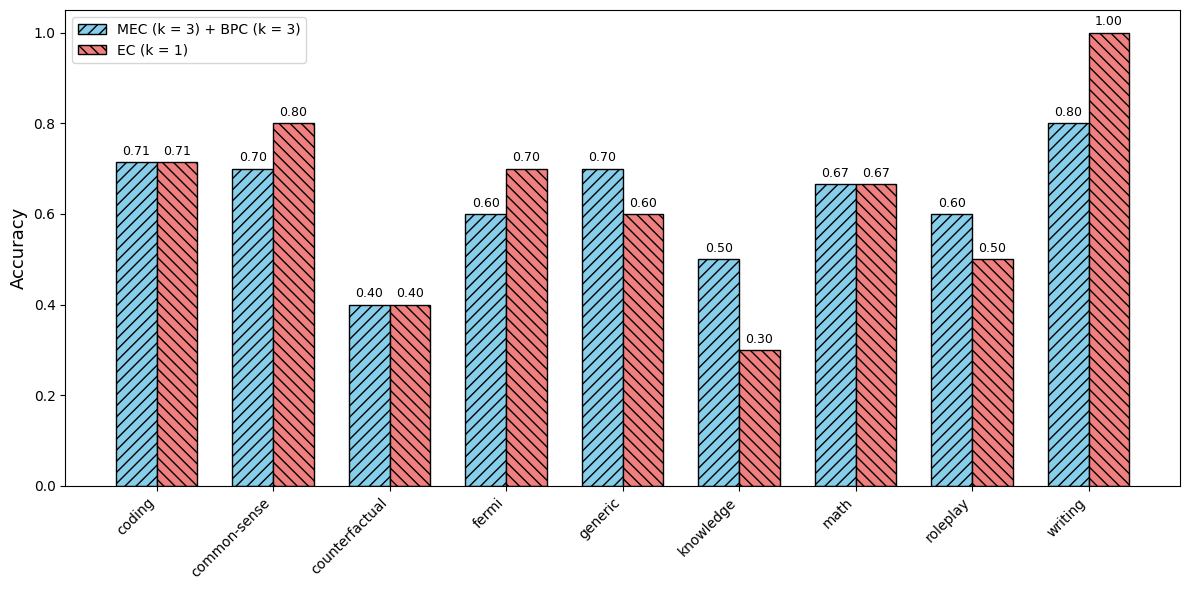

In [22]:
plot_grouped_accuracy_bars(gpt4_best_category_acc, gpt4_worst_category_acc, second_label="EC (k = 1)", first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt4_categories.png)

## GPT 3.5
Calculate the accuracy across categories for GPT 3.5

In [23]:
gpt3_5_best_category_acc = judgement_result[f"gpt35_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_best_category_acc

category
coding            0.857143
common-sense      0.600000
counterfactual    0.500000
fermi             0.400000
generic           0.600000
knowledge         0.600000
math              0.666667
roleplay          0.500000
writing           0.800000
Name: result_hit, dtype: float64

In [24]:
gpt3_5_worst_category_acc = judgement_result[f"gpt35_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_worst_category_acc

category
coding            0.857143
common-sense      0.800000
counterfactual    0.500000
fermi             0.600000
generic           0.600000
knowledge         0.500000
math              1.000000
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

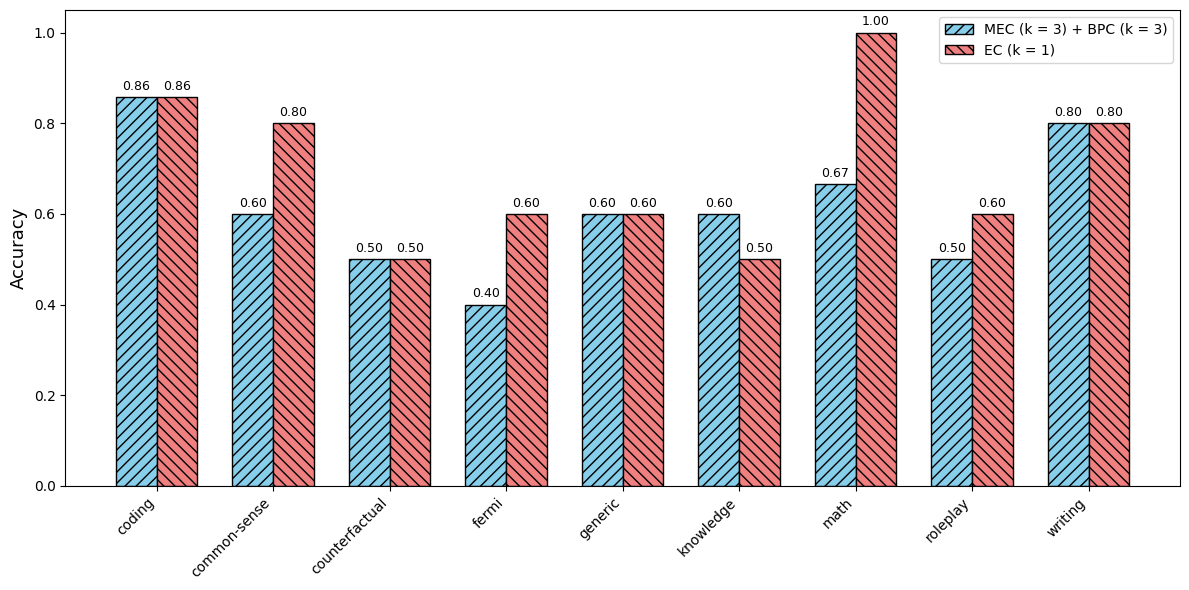

In [25]:
plot_grouped_accuracy_bars(gpt3_5_best_category_acc, gpt3_5_worst_category_acc, second_label="EC (k = 1)", first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt3_5_categories.png)